In [4]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


In [21]:
class Common_Class():

  def __init__(self, symbol, start, end, interval, capital, transcation_cost, verbose = True):

    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital # this is the initial capital you want to trade with
    self.capital = capital # this capital will change depending on trades
    self. transaction_cost = transcation_cost # the transaction cost for trading
    self.quantity = 0 # quantities to buy/sell
    self.position = 0 # the trades in progress, long or short
    self.trades = 0 # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)

    self.prepare_data() # prepares the data

  def prepare_data(self):
    # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
    # we will calculate the returns though.
    # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.

    stock_data = yf.Ticker(self.symbol)
    hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)

    bt_data = pd.DataFrame()
    bt_data["Close_Price"] = hist_stock["Close"]
    bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
    bt_data = bt_data.dropna()
    self.data = bt_data

  def close_graph(self):
    plt.figure(figsize=(15, 5))
    plt.plot(self.data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of {}".format(self.symbol))
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, bar):

    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date

    date = str(self.data.index[bar])[:10] #First 10 contains the date elements, rest is time
    price = self.data.Close_Price.iloc[bar]
    return date, price

  def realised_balance(self, bar):

    #Returns you the realised capital in your account at a given time period / bar

    date, price = self.return_date_price(bar)
    print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

  def unrealised_balance(self, bar):

    #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar

    date, price = self.return_date_price(bar)
    ub = self.quantity *price
    print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

  def total_balance(self, bar):

    #Unrealised plus realised

    date, price = self.return_date_price(bar)
    tb = self.quantity *price + self.capital
   # tb = self.quantity *price + self.capital
    print("Date :{} | Total Balance: {:0.1f}".format(date,tb))

  def buy_order(self,bar,quantity=None, dollar =None ):
    date, price = self.return_date_price(bar)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity = self.quantity + quantity
    self.trades = self.trades + 1
    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,self.symbol, price, quantity * price))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)


  def sell_order(self,bar,quantity=None, dollar=None ):
    date, price = self.return_date_price(bar)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity = self.quantity - quantity
    self.trades = self.trades + 1
    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,self.symbol, price, quantity * price))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)
  

  def compute_sharpe_ratio(self):
      avg_returns = self.data['Return'].mean()
      std = self.data['Return'].std()
      daily_SR = avg_returns / std
      annual_SR = daily_SR * (252 ** 0.5)
      return round(annual_SR, 2)
  

  def compute_drawdown(self):
      cum_returns = (1 + self.data['Return']).cumprod()
      peak = cum_returns.expanding(min_periods=1).max()
      drawdown = (cum_returns / peak) - 1
      return round(drawdown.min(), 2)
  

  def compute_calmar_ratio(self):
      annual_return = (1 + self.data['Return']).prod() ** (252 / len(self.data)) - 1
      max_drawdown = self.compute_drawdown()
      if max_drawdown < 0:
          calmar = annual_return / abs(max_drawdown)
      else:
          calmar = np.nan
      return round(calmar, 2)


  def last_trade(self, bar):
    date, price = self.return_date_price(bar)
    last_quantity = self.quantity # this variable to print and store as self.quantity will be set to 0 later
    self.capital = self.capital + self.quantity * price
    self.quantity = 0 # as no more quantity now. all will be settled
    self.trades = self.trades +1
    if self.verbose:
      print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,self.symbol, price, last_quantity * price))
      self.total_balance(bar)

      returns = (self.capital - self.initial_capital) /self.initial_capital *100
      print("The total capital at end of strategy: {:0.1f}".format(self.capital))
      print( "The strategy returns on investment are {:0.1f} %".format(returns))
      print( "Total trades by startegy are {:0.1f}".format(self.trades))
      print( "Sharpe Ratio: {:0.1f}".format(self.compute_sharpe_ratio()))
      print( "Max Drawdown: {:0.1f}".format(self.compute_drawdown()))
      print( "Calmar Ratio: {:0.1f}".format(self.compute_calmar_ratio()))


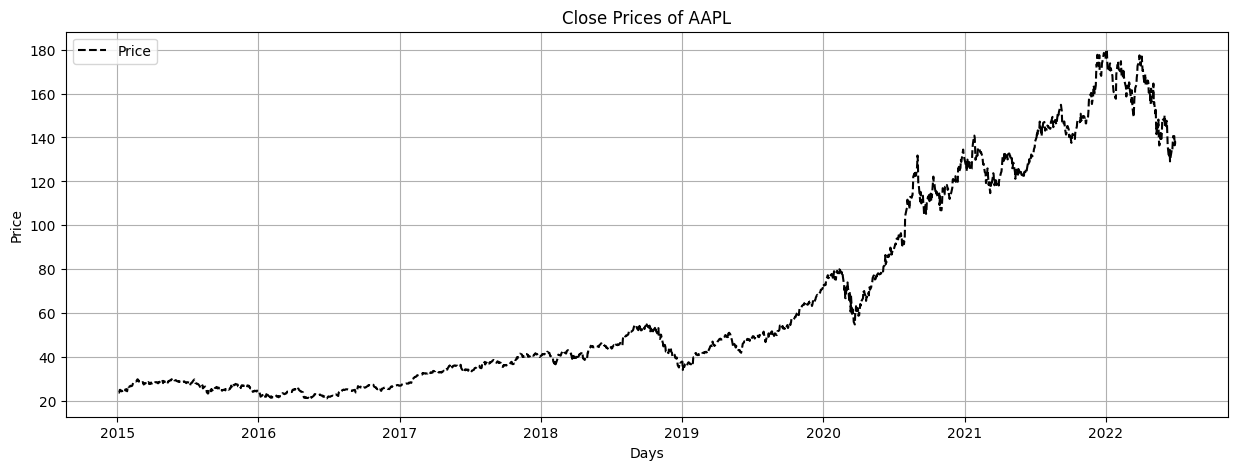

In [22]:
if __name__ == "__main__":
  A = Common_Class("AAPL", "2015-01-01", "2022-07-01","1d",10000, 0.0, True)
  A.close_graph()
  

In [23]:
class MA_Strategy(Common_Class):

  def go_long(self, bar, quantity = None, dollar = None):
    if self.position == -1:
      self.buy_order(bar, quantity = -self.quantity) # to clear previous short position and therefore negative quantity
    if quantity:
      self.buy_order(bar, quantity=quantity) # to create new fresh order
    elif dollar:
      if dollar == "all":
        dollar = self.capital
      self.buy_order(bar,dollar=dollar)
      
  def go_short(self, bar, quantity = None, dollar = None):
    if self.position == 1:
      self.sell_order(bar, quantity = self.quantity) # to clear previous long position
    if quantity:
      self.sell_order(bar, quantity=quantity) # to create new fresh order
    elif dollar:
      if dollar == "all":
        dollar = self.capital
      self.sell_order(bar,dollar=dollar)  

  def run_strategy(self, STMA_window, LTMA_window):
    self.position = 0
    self.trades = 0
    self.capital = self.initial_capital
    indicator_1 = SMAIndicator (close = self.data["Close_Price"], window = STMA_window, fillna= False)
    STMA = indicator_1.sma_indicator()
    indicator_2 = SMAIndicator (close = self.data["Close_Price"], window = LTMA_window, fillna= False)
    LTMA = indicator_2.sma_indicator ()

    self.data["STMA"] = STMA
    self.data["LTMA"] = LTMA

    for bar in range(LTMA_window, len(self.data)):
      if self.position in [0, -1]: # checking no position or short position 1f self. data ["STMA*].11oc [bar]›self. data ["LTMA"].11oc [bar]: self.go_long(bar, dollar-"all") # go with all money self.position - 1 # long created print("
        if self.data['STMA'].iloc[bar] > self.data['LTMA'].iloc[bar]:
          self.go_long(bar, dollar = "all")
          self.position = 1
          print('-------')
      if self.position in [0,1]:
        if self.data['STMA'].iloc[bar] < self.data['LTMA'].iloc[bar]:
          self.go_short(bar,dollar = "all")
          self.position = -1
          print('-------')
    print('-------')
    self.last_trade(bar)
    

In [24]:
if __name__ == "__main__":
  A = MA_Strategy("AAPL", "2010-04-10", "2022-07-01","1d",10000, 0.01, True)
  A.run_strategy(50,200)

Bought 959 shares of AAPL at 10.4 per share worth 9996.2 $
Date :2011-01-26 | Realised Balance: -96.1
Date :2011-01-26 | Unrealised Balance: 9996.2
Date :2011-01-26 | Total Balance: 9900.0
-------
Sold 959 shares of AAPL at 16.2 per share worth 15539.3 $
Date :2012-12-10 | Realised Balance: 15287.8
Date :2012-12-10 | Unrealised Balance: 0.0
Date :2012-12-10 | Total Balance: 15287.8
Sold 943 shares of AAPL at 16.2 per share worth 15280.1 $
Date :2012-12-10 | Realised Balance: 30415.1
Date :2012-12-10 | Unrealised Balance: -15280.1
Date :2012-12-10 | Total Balance: 15135.0
-------
Bought 943 shares of AAPL at 15.4 per share worth 14539.0 $
Date :2013-09-10 | Realised Balance: 15730.7
Date :2013-09-10 | Unrealised Balance: 0.0
Date :2013-09-10 | Total Balance: 15730.7
Bought 1020 shares of AAPL at 15.4 per share worth 15726.1 $
Date :2013-09-10 | Realised Balance: -152.7
Date :2013-09-10 | Unrealised Balance: 15726.1
Date :2013-09-10 | Total Balance: 15573.5
-------
Sold 1020 shares of AA